# Task 1: Dataset Exploration
> "Makes a diff'rence, havin' a decent family" ~Rubeus

## Objective
Explore the family knowledge graph structure, compute relevant statistics, and uncover patterns using graph theory concepts.

In [34]:
# Import libraries
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib.lines import Line2D
import math
sns.set_theme(style="whitegrid", context="talk")



In [35]:
#Extract the triplets from the file
file_path = "train.txt"
triples = []
with open(file_path) as f:
    for line in f:
        h, r, t = line.strip().split()
        triples.append((h, r, t))


In [36]:
#Make a graph from the extracted triplets
G = nx.MultiDiGraph()

for h, r, t in triples:
    G.add_edge(h, t, relation=r)

print(f"Total no. of people in the graph: {G.number_of_nodes()}\nTotal no. of relatations accross everyone: {G.number_of_edges()}")

Total no. of people in the graph: 1316
Total no. of relatations accross everyone: 13821


In [37]:
#Find all types of relations
relations = [r for (_, r, _) in triples]
unique_relations = set(relations)
print(f"Total no. of unique relations: {len(unique_relations)}\nThe unique relations are:{unique_relations}")


Total no. of unique relations: 28
The unique relations are:{'granddaughterOf', 'girlCousinOf', 'nephewOf', 'greatGranddaughterOf', 'uncleOf', 'secondUncleOf', 'grandmotherOf', 'sonOf', 'sisterOf', 'greatAuntOf', 'boyCousinOf', 'daughterOf', 'auntOf', 'greatGrandfatherOf', 'grandsonOf', 'boyFirstCousinOnceRemovedOf', 'brotherOf', 'grandfatherOf', 'fatherOf', 'boySecondCousinOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatUncleOf', 'nieceOf', 'girlFirstCousinOnceRemovedOf', 'secondAuntOf', 'motherOf', 'girlSecondCousinOf'}


In [38]:
#Find counts of each relation
relation_counts = Counter(relations)

df_rel = pd.DataFrame(relation_counts.items(), columns=["Relation", "Count"])
df_rel = df_rel.sort_values("Count", ascending=False)

df_rel

,Relation,Count
18,grandsonOf,814
8,grandmotherOf,813
15,grandfatherOf,813
4,granddaughterOf,812
6,motherOf,733
14,fatherOf,733
0,sisterOf,636
3,daughterOf,628
27,greatGrandsonOf,624
23,greatGrandmotherOf,617


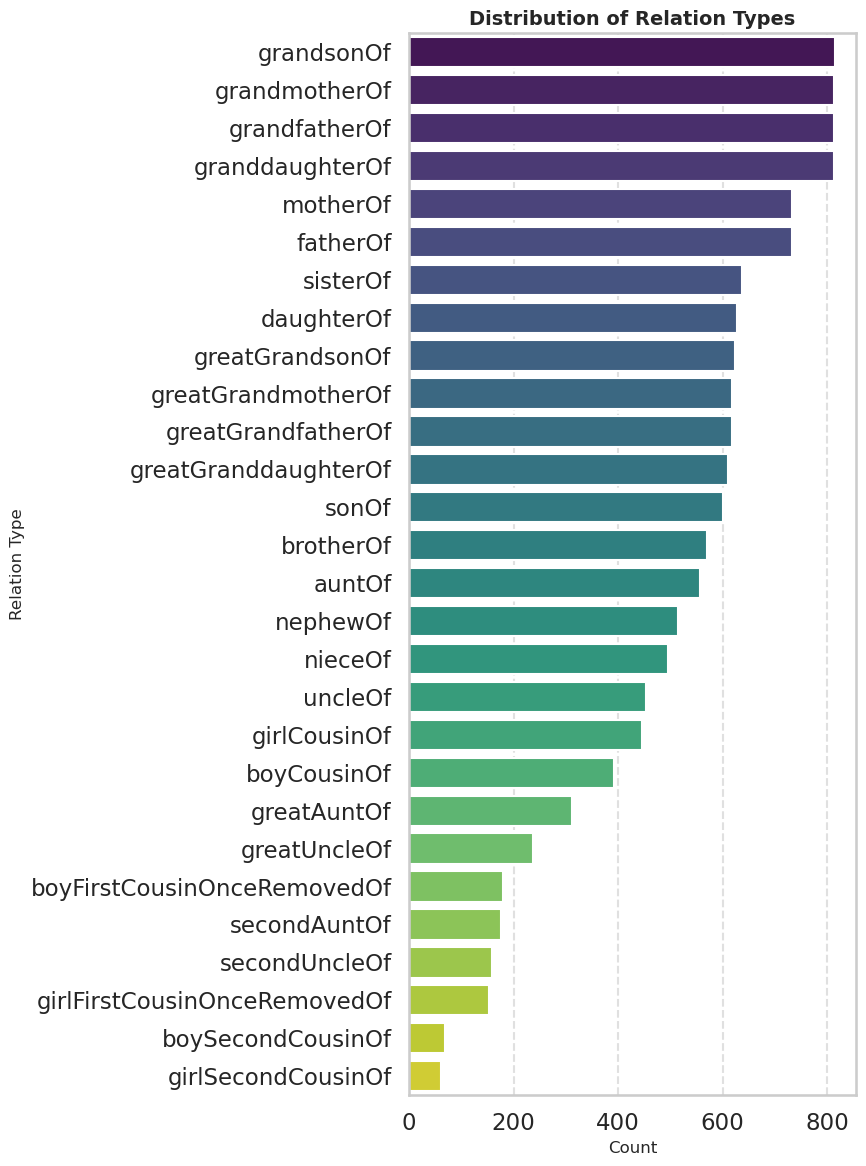

In [39]:
#Plot the counts of each relation
plt.figure(figsize=(9, 12))
sns.barplot(
    data=df_rel,
    y="Relation",
    x="Count",
    hue="Relation",
    palette="viridis"
)

plt.title("Distribution of Relation Types", fontsize=14, weight="bold")
plt.xlabel("Count", fontsize=12)
plt.ylabel("Relation Type", fontsize=12)

plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

**Insight:** Grandparent relations (`grandsonOf`, `grandmotherOf`, etc.) are the most frequent, followed by parent-child relations. This indicates families span at least 3 generations with grandparents being central connectors.

In [40]:
#Conver directed multi graph to undirected (single edge)graphs
H = nx.Graph(G)

degrees = [d for _, d in H.degree()]

min(degrees), max(degrees), sum(degrees)/len(degrees)


(1, 23, 11.367781155015198)

In [41]:
#Find degree of each node
degree_counts = Counter(degrees)
df_deg = pd.DataFrame({
    "Degree": list(degree_counts.keys()),
    "Count": list(degree_counts.values())
}).sort_values("Degree")


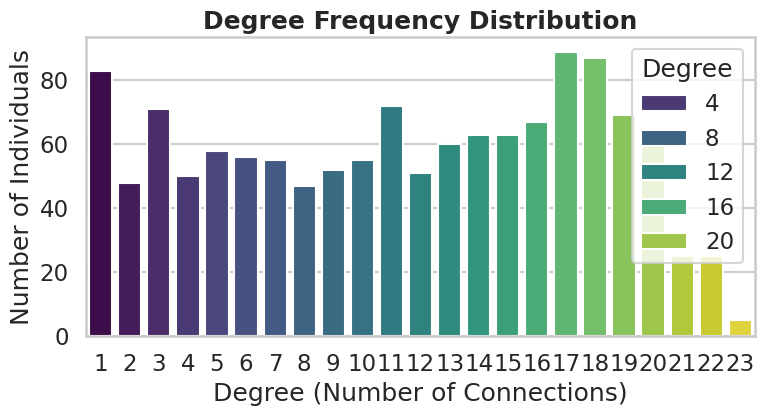

In [42]:
#Plot the degree freq. for all individuals
plt.figure(figsize=(8,4.5))
sns.barplot(
    data=df_deg,
    x="Degree",
    y="Count",
    hue="Degree",
    palette="viridis"   
)

plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Number of Individuals")
plt.title("Degree Frequency Distribution", weight="bold")

plt.tight_layout()
plt.show()

**Insight:** Write it

In [43]:
#Finding no. of disconnected components
components = list(nx.connected_components(H))
print(f"Total no. of families: {len(components)}")

Total no. of families: 50


**Insight:** 50 disconnected families exist with zero inter-family connections. Each family is a self-contained component.

In [44]:
#Finding range of familiy sizes
sizes = [len(c) for c in components]

print(f"Max family size: {max(sizes)}\nMin family size: {min(sizes)}")


Max family size: 27
Min family size: 26


In [45]:
#Storing each family as a seperate entity
#Each families head is represented by the max degree person
families = {}

for i, comp in enumerate(components, start=1):
    sub_H = H.subgraph(comp).copy()   
    sub_G = G.subgraph(comp).copy()   
    
    degrees_sub = dict(sub_H.degree())
    head = max(degrees_sub, key=degrees_sub.get)
    
    fam_id = f"F{i}"   
    
    families[fam_id] = {
        "head": head,
        "H": sub_H,   
        "G": sub_G    
    }


In [46]:
n = len(components)
cols = 5
rows = math.ceil(n / cols)

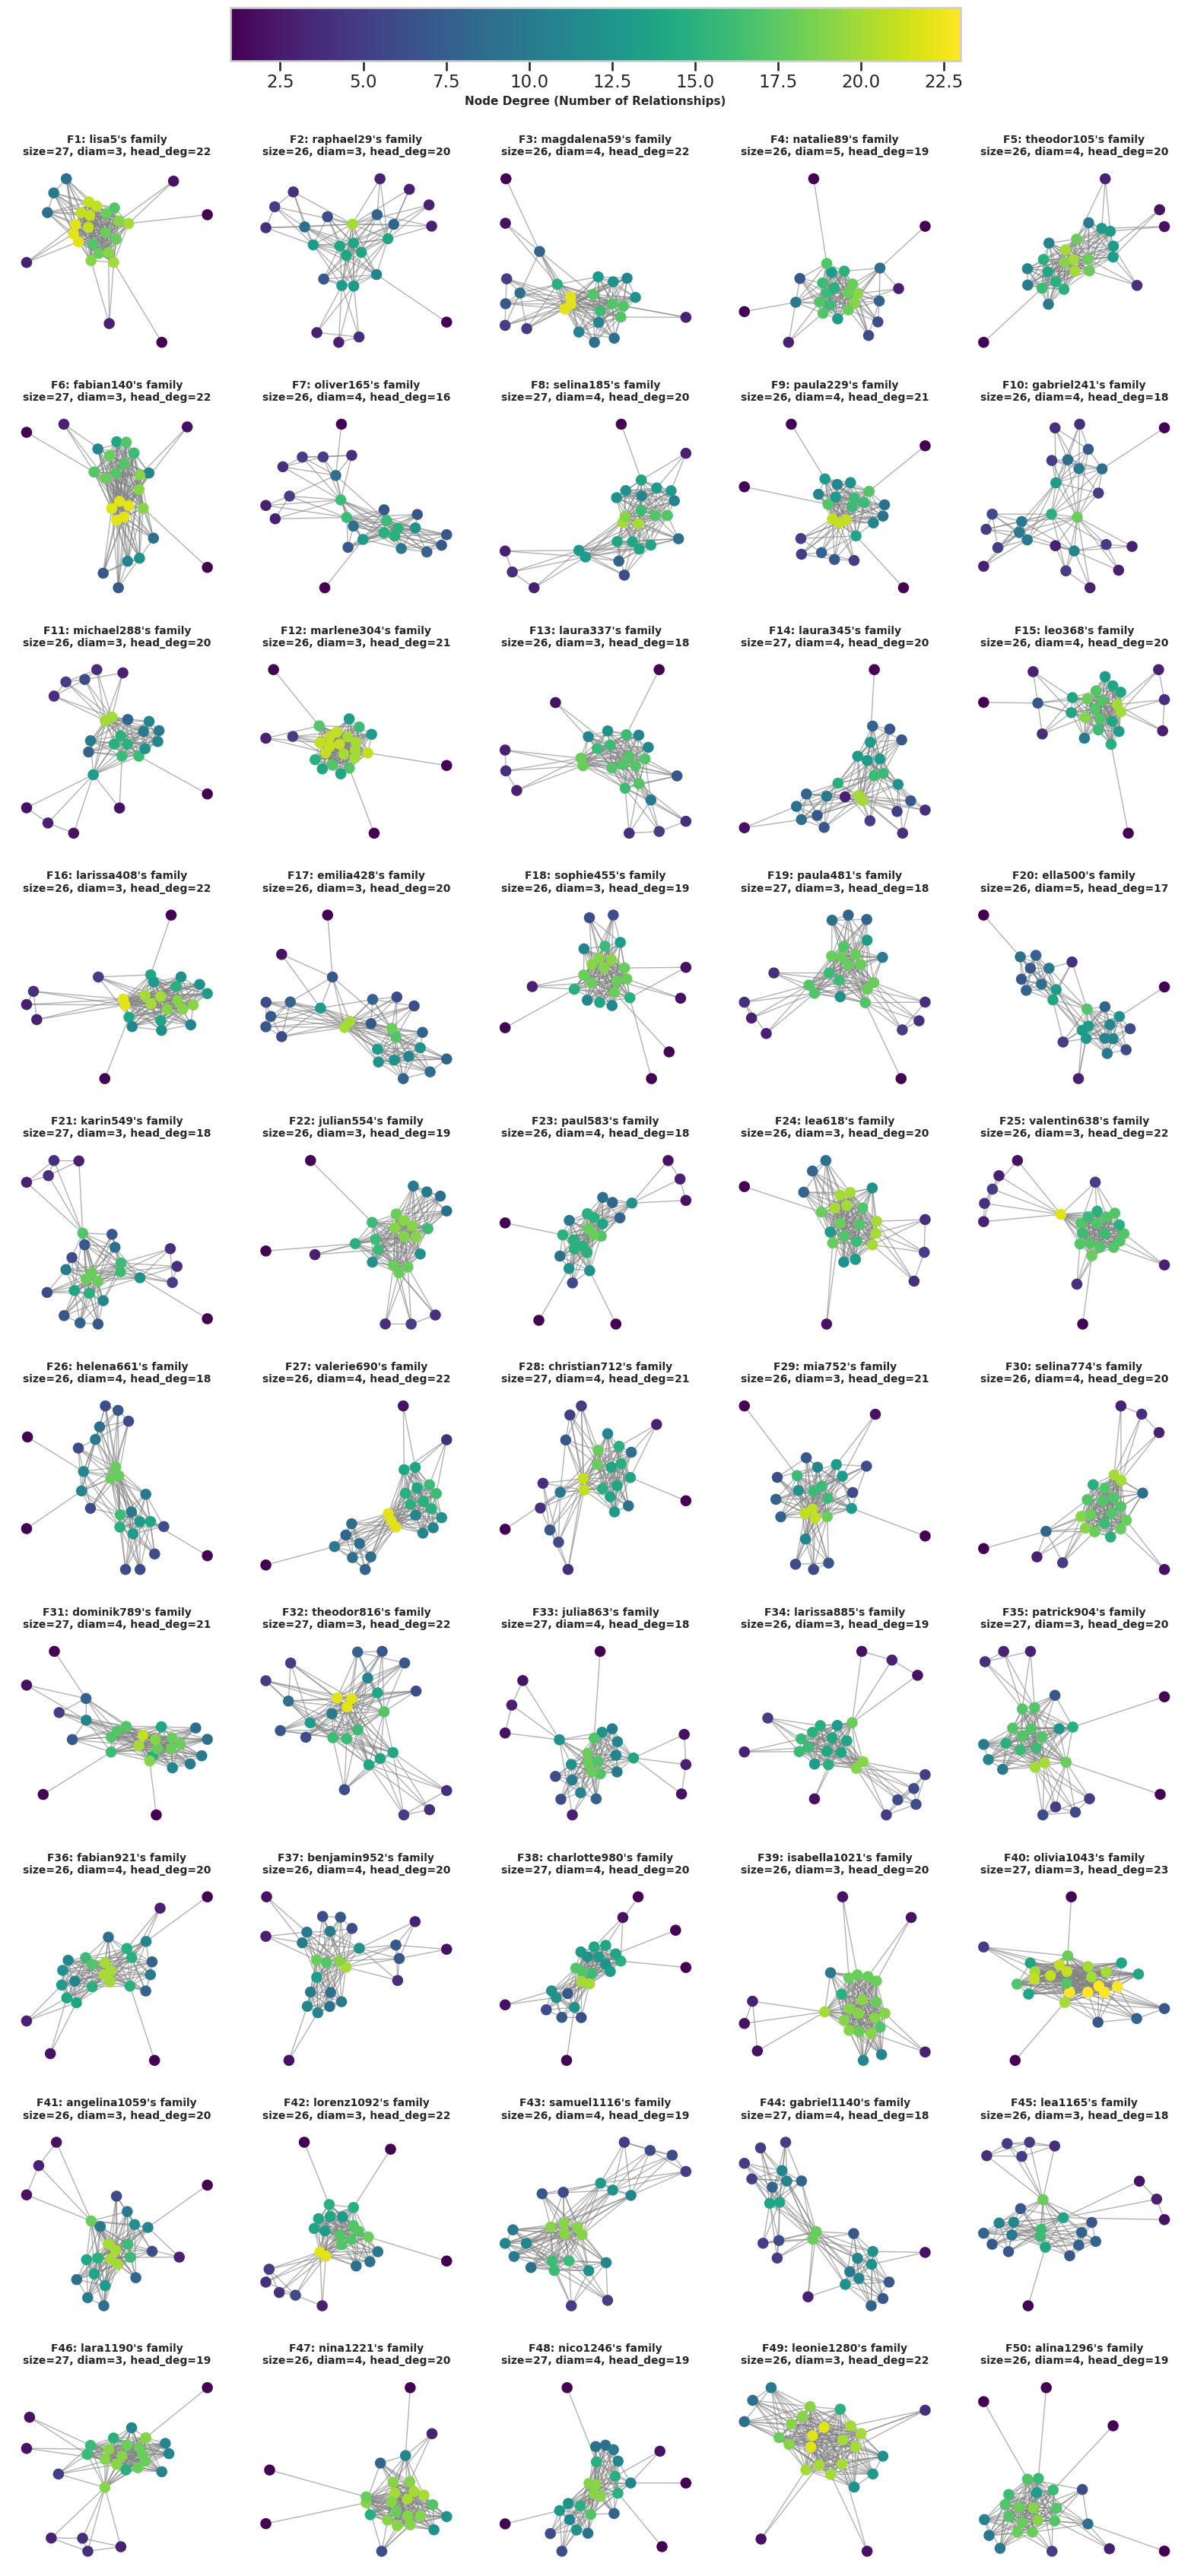

In [47]:
#Plot all the amilies with color coded degrees

fig = plt.figure(figsize=(16, 3.5 * rows))

axes = []
all_degrees = []

for fam in families.values():
    sub = fam["H"]
    all_degrees.extend([d for _, d in sub.degree()])

vmin = min(all_degrees)
vmax = max(all_degrees)

for i, (fam_id, fam) in enumerate(families.items()):
    sub = fam["H"]
    head = fam["head"]
    
    pos = nx.spring_layout(sub, seed=42)

    degrees_sub = dict(sub.degree())
    node_colors = list(degrees_sub.values())
    head_deg = degrees_sub.get(head, 0)

    ax = fig.add_subplot(rows, cols, i + 1)
    axes.append(ax)

    nodes = nx.draw_networkx_nodes(
        sub, pos,
        node_size=80,
        node_color=node_colors,
        cmap=plt.cm.viridis,
        vmin=vmin,
        vmax=vmax,
        ax=ax
    )
    nx.draw_networkx_edges(sub, pos, edge_color="gray", alpha=0.6, ax=ax)

    size = sub.number_of_nodes()
    diameter = nx.diameter(sub)

    ax.set_title(
        f"{fam_id}: {head}'s family\n"
        f"size={size}, diam={diameter}, head_deg={head_deg}",
        fontsize=10,
        fontweight="bold"
    )

    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.93])

cax = fig.add_axes([0.2, 0.95, 0.6, 0.02])
cbar = fig.colorbar(nodes, cax=cax, orientation="horizontal")
cbar.set_label("Node Degree (Number of Relationships)", fontsize=11, fontweight="bold")

plt.show()


**Insight:** Family structures vary in size and shape. Brighter nodes (higher degree) indicate central figures - typically grandparents who connect multiple branches.

In [ ]:
#Find the degree centrality and store them for each family
for fam_id, fam in families.items():
    sub = fam["H"]
    deg_cent = nx.degree_centrality(sub)
    
    fam["degree_centrality"] = deg_cent
    fam["max_degree_centrality"] = max(deg_cent.values())
    fam["avg_degree_centrality"] = sum(deg_cent.values()) / len(deg_cent)


In [66]:
sorted_items = sorted(
    families.items(),
    key=lambda x: x[1]["max_degree_centrality"],
    reverse=True
)
labels = [fam_id for fam_id, _ in sorted_items]
max_vals = [fam["max_degree_centrality"] for _, fam in sorted_items]
avg_vals = [fam["avg_degree_centrality"] for _, fam in sorted_items]


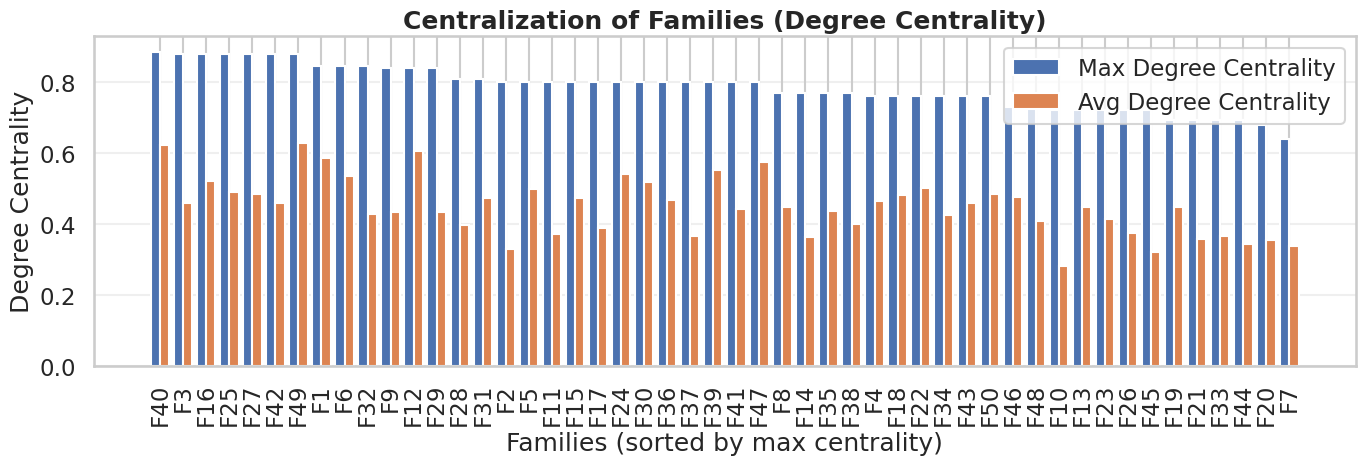

In [ ]:
#Plot the max degree centrality and avg degree centrality together 
x = np.arange(len(max_vals))
width = 0.4

plt.figure(figsize=(14,5))

plt.bar(x - width/2, max_vals, width, label="Max Degree Centrality")
plt.bar(x + width/2, avg_vals, width, label="Avg Degree Centrality")

plt.xlabel("Families (sorted by max centrality)")
plt.ylabel("Degree Centrality")
plt.title("Centralization of Families (Degree Centrality)", weight="bold")

plt.xticks(x, labels, rotation=90)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


**Insight:** High max centrality with low average indicates one dominant "hub" person (likely a grandparent). When max ≈ avg, the family has more distributed connections without a single authority figure.

In [ ]:
#Find the betwenness and store them for each family
for fam_id, fam in families.items():
    sub = fam["H"] 
    
    bet = nx.betweenness_centrality(sub, normalized=True)
    fam["betweenness"] = bet
    
    top_person = max(bet, key=bet.get)

    
    fam["top_bet_person"] = top_person
    fam["top_bet_value"] = bet[top_person]
    fam["avg_bet"] = sum(bet.values()) / len(bet)


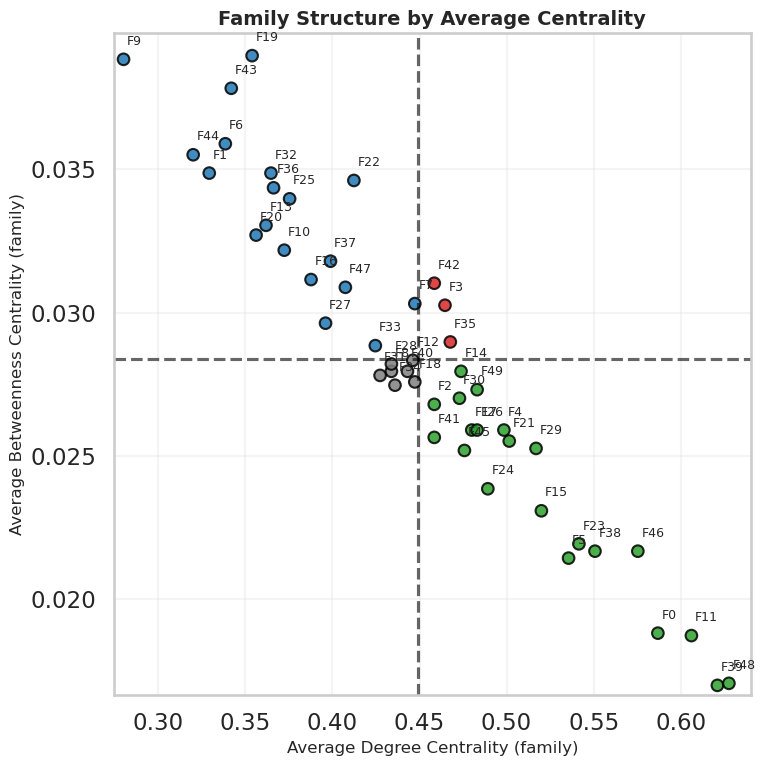

In [ ]:
#Plot between avg degree centrality and avd bet. centrality
avg_deg_vals = []
avg_bet_vals = []

for fam in families.values():
    avg_deg_vals.append(np.mean(list(fam["degree_centrality"].values())))
    avg_bet_vals.append(np.mean(list(fam["betweenness"].values())))

avg_deg_vals = np.array(avg_deg_vals)
avg_bet_vals = np.array(avg_bet_vals)

mean_deg = np.mean(avg_deg_vals)
mean_bet = np.mean(avg_bet_vals)

colors = []
for d, b in zip(avg_deg_vals, avg_bet_vals):
    if d >= mean_deg and b >= mean_bet:
        colors.append("#d62728")  
    elif d >= mean_deg and b < mean_bet:
        colors.append("#2ca02c")  
    elif d < mean_deg and b >= mean_bet:
        colors.append("#1f77b4")  
    else:
        colors.append("#7f7f7f")  

plt.figure(figsize=(8,8))
plt.scatter(avg_deg_vals, avg_bet_vals, c=colors, s=70,
            edgecolor="black", alpha=0.85)

# mean reference lines
plt.axhline(mean_bet, color="black", linestyle="--", alpha=0.6)
plt.axvline(mean_deg, color="black", linestyle="--", alpha=0.6)

plt.xlabel("Average Degree Centrality (family)", fontsize=12)
plt.ylabel("Average Betweenness Centrality (family)", fontsize=12)
plt.title("Family Structure by Average Centrality", fontsize=14, weight="bold")



top_idx = np.argsort(avg_bet_vals)[-50:]
for i in top_idx:
    plt.text(avg_deg_vals[i] + 0.002, avg_bet_vals[i] + 0.0005,
             f"F{i}", fontsize=9)

plt.xlim(avg_deg_vals.min()*0.98, avg_deg_vals.max()*1.02)
plt.ylim(avg_bet_vals.min()*0.98, avg_bet_vals.max()*1.02)

plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


**Insight:** You can see a downward pattern: as average degree increases, average betweenness decreases.

*Interpretation:*

Families where many members are well connected tend to distribute shortest paths, so no one node carries high routing load.

Sparse families force more paths through fewer connectors -> higher average betweenness.



In [ ]:
# Find diff params for families and store them
for fam_id, data in families.items():
    H_fam = data["H"]
    
    n = H_fam.number_of_nodes()
    
    if n > 2 and nx.is_connected(H_fam):
        density = nx.density(H_fam)
        clustering = nx.average_clustering(H_fam)
        diameter = nx.diameter(H_fam)
        avg_path = nx.average_shortest_path_length(H_fam)
    else:
        density = None
        clustering = None
        diameter = None
        avg_path = None
    
    families[fam_id]["density"] = density
    families[fam_id]["clustering"] = clustering
    families[fam_id]["diameter"] = diameter
    families[fam_id]["avg_path_length"] = avg_path


In [ ]:
# convert the metrics into pd df
family_ids = []
clusterings = []
diameters = []
densities = []
avg_paths = []

for fam_id, data in families.items():
    if data["clustering"] is not None and data["diameter"] is not None:
        family_ids.append(fam_id)
        clusterings.append(data["clustering"])
        diameters.append(data["diameter"])
        densities.append(data["density"])
        avg_paths.append(data["avg_path_length"])

df_metrics = pd.DataFrame({
    "family": family_ids,
    "clustering": clusterings,
    "diameter": diameters,
    "density": densities,
    "avg_path_length": avg_paths
})


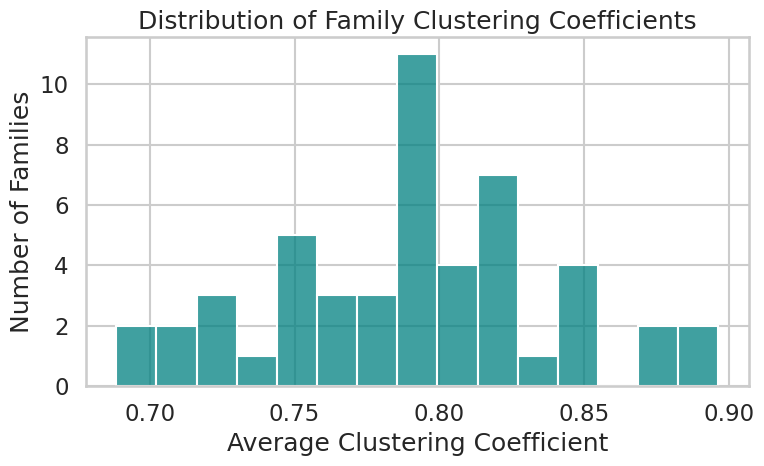

In [70]:
plt.figure(figsize=(8,5))
sns.histplot(df_metrics["clustering"], bins=15, color="teal")
plt.xlabel("Average Clustering Coefficient")
plt.ylabel("Number of Families")
plt.title("Distribution of Family Clustering Coefficients")
plt.tight_layout()
plt.show()


**Insight:** High clustering (0.69-0.90, avg 0.79) confirms strong local connectivity neighbors of a person tend be also are connected in the graph (e.g., siblings share the same parents).

## Graph Metrics: Clustering & Diameter

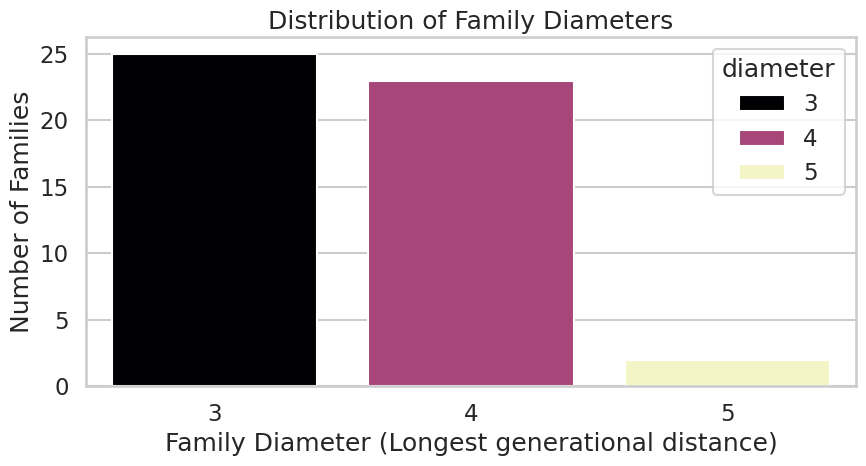

In [ ]:
#Plot diameter vs no. of families
plt.figure(figsize=(9,5))

ax = sns.countplot(x=df_metrics["diameter"],hue=df_metrics["diameter"],palette="magma")

plt.xlabel("Family Diameter (Longest generational distance)")
plt.ylabel("Number of Families")
plt.title("Distribution of Family Diameters")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


**Insight:** Diameter ranges from 3-5 hops. This represents the longest shortest path between any two members - the most distant relatives in each family.

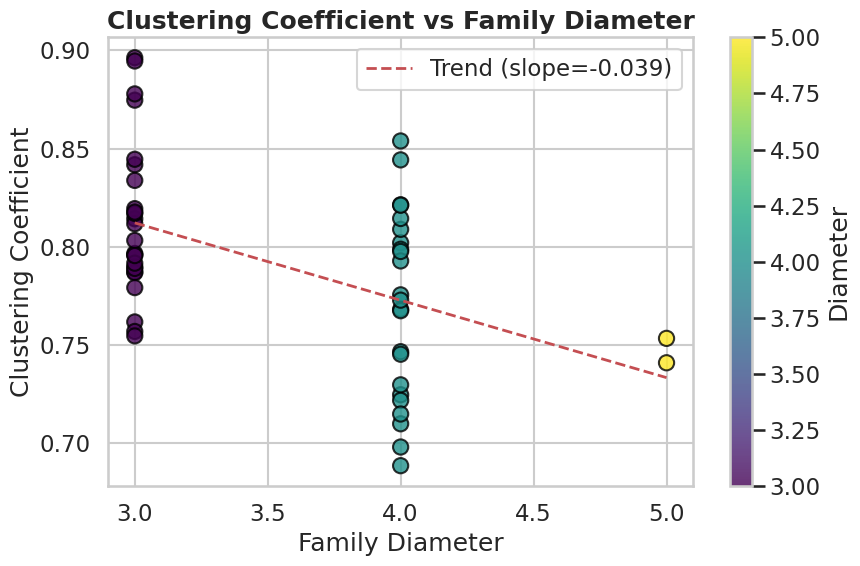

Correlation between diameter and clustering: -0.472


In [ ]:
#Plot Clustering Coef vs Diam
plt.figure(figsize=(9, 6))

scatter = plt.scatter(
    df_metrics["diameter"], 
    df_metrics["clustering"],
    c=df_metrics["diameter"],
    cmap="viridis",
    s=120,
    edgecolor="black",
    alpha=0.8
)

z = np.polyfit(df_metrics["diameter"], df_metrics["clustering"], 1)
p = np.poly1d(z)
x_line = np.linspace(df_metrics["diameter"].min(), df_metrics["diameter"].max(), 100)
plt.plot(x_line, p(x_line), "r--", linewidth=2, label=f"Trend (slope={z[0]:.3f})")

plt.xlabel("Family Diameter")
plt.ylabel("Clustering Coefficient")
plt.title("Clustering Coefficient vs Family Diameter", weight="bold")
plt.legend()
plt.colorbar(scatter, label="Diameter")
plt.tight_layout()
plt.show()

corr = df_metrics["diameter"].corr(df_metrics["clustering"])
print(f"Correlation between diameter and clustering: {corr:.3f}")

**Insight:** Negative correlation (r = -0.47) - as families grow larger (higher diameter), clustering decreases. Larger families become more spread out with less overlap between neighbor groups.
Clustering decreases with diameter (slope ≈ −0.039, correlation r ≈ −0.47), indicating a moderate negative association.

In [ ]:
# Assign shift per gen to find generations in a family
gen_shift = {
    # parent 
    "motherOf": 1,
    "fatherOf": 1,
    "daughterOf": -1,
    "sonOf": -1,
    
    # grandparent 
    "grandmotherOf": 2,
    "grandfatherOf": 2,
    "granddaughterOf": -2,
    "grandsonOf": -2,
    
    # great-grandparent 
    "greatGrandmotherOf": 3,
    "greatGrandfatherOf": 3,
    "greatGranddaughterOf": -3,
    "greatGrandsonOf": -3,
    
    # same generation (horizontal)
    "sisterOf": 0,
    "brotherOf": 0,
    "boyCousinOf": 0,
    "girlCousinOf": 0,
    "boySecondCousinOf": 0,
    "girlSecondCousinOf": 0,
    "boyFirstCousinOnceRemovedOf": 0,
    "girlFirstCousinOnceRemovedOf": 0,
    
    
    "auntOf": 1,
    "uncleOf": 1,
    "nieceOf": -1,
    "nephewOf": -1,
    "greatAuntOf": 2,
    "greatUncleOf": 2,
    "secondAuntOf": 1,
    "secondUncleOf": 1
}


In [ ]:
# Build a directed generation-shift graph for each family'
for fam_id, data in families.items():
    G_fam = data["G"]  
    
    G_gen = nx.DiGraph() 
    
    for u, v, attr in G_fam.edges(data=True):
        r = attr["relation"]
        
        if r in gen_shift:
            shift = gen_shift[r]
            G_gen.add_edge(u, v, weight=shift)
    
    families[fam_id]["gen_graph"] = G_gen


In [ ]:
# Compute relative generation levels for each person using BFS-style forward/backward 
for fam_id, data in families.items():
    G_gen = data["gen_graph"]
    
   
    roots = [n for n in G_gen.nodes() if G_gen.in_degree(n) == 0]
    if not roots:
        roots = [next(iter(G_gen.nodes()))]
    
    generation = {r: 0 for r in roots}
    
    visited = set(generation.keys())
    queue = list(generation.keys())
    
    while queue:
        u = queue.pop(0)
        # Forward propagation 
        for v in G_gen.successors(u):
            if v not in visited:
                w = G_gen[u][v]['weight']
                generation[v] = generation[u] + w
                visited.add(v)
                queue.append(v)
        # Backward propagation 
        for v in G_gen.predecessors(u):
            if v not in visited:
                w = G_gen[v][u]['weight']
                generation[v] = generation[u] - w
                visited.add(v)
                queue.append(v)
    
    families[fam_id]["generation_islands"] = generation


In [ ]:
# Group family members into generation islands
for fam_id, data in families.items():
    gen = data["generation_islands"]
    
    islands = {}
    for person, g in gen.items():
        islands.setdefault(g, []).append(person)
    
    families[fam_id]["islands"] = islands


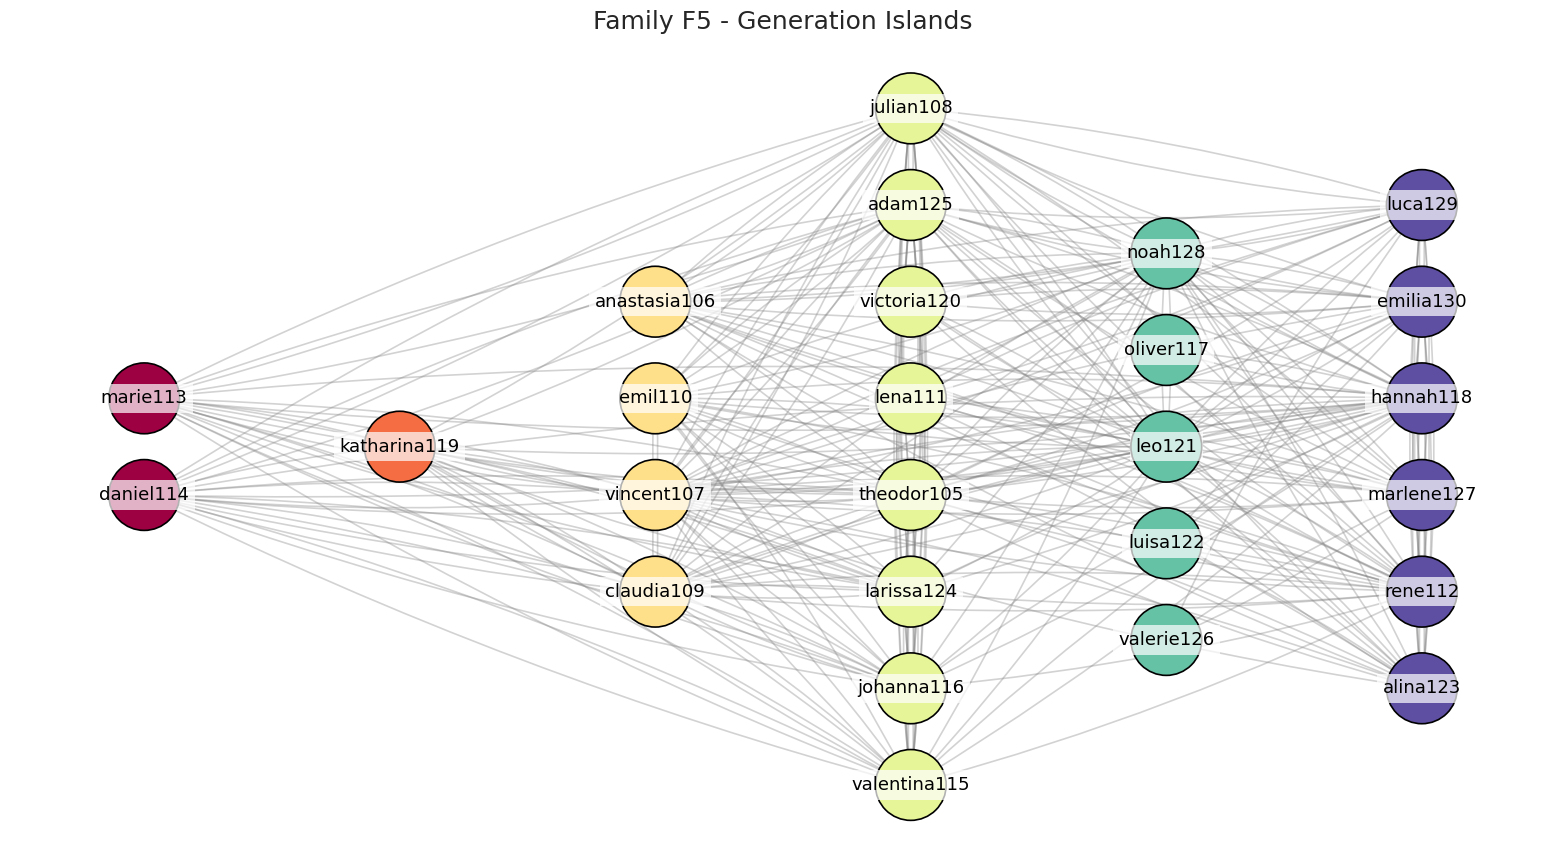

In [ ]:
fam_id = "F5" # Edits thsi id to change to a diff family
data = families[fam_id]

G_gen = data["gen_graph"]
islands = data["islands"]

for g, nodes in islands.items():
    for n in nodes:
        G_gen.nodes[n]["subset"] = g

plt.figure(figsize=(16,9))

pos = nx.multipartite_layout(G_gen, subset_key="subset", scale=2.5)

nx.draw_networkx_edges(
    G_gen, pos,
    edge_color="gray",
    alpha=0.35,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=18,
    width=1.2,
    connectionstyle="arc3,rad=0.05"   
)

nx.draw_networkx_nodes(
    G_gen, pos,
    node_color=[G_gen.nodes[n]["subset"] for n in G_gen.nodes()],
    cmap=plt.cm.Spectral,
    node_size=2600,
    edgecolors="black",
    linewidths=1.2
)

nx.draw_networkx_labels(
    G_gen, pos,
    font_size=13,
    font_color="black",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7)
)

plt.title(f"Family {fam_id} - Generation Islands", fontsize=18)
plt.axis("off")
plt.tight_layout()
plt.show()


**Insight:** Generation islands show clear vertical hierarchy. Arrows flow from older to younger generations. Colors represent generation level - this visualization confirms the relation-based generation assignment works correctly.

In [64]:
for fam_id, data in families.items():
    islands = data["islands"]
    
    if islands:
        num_gens = len(islands)   
    else:
        num_gens = 0
    
    families[fam_id]["num_generations_islands"] = num_gens


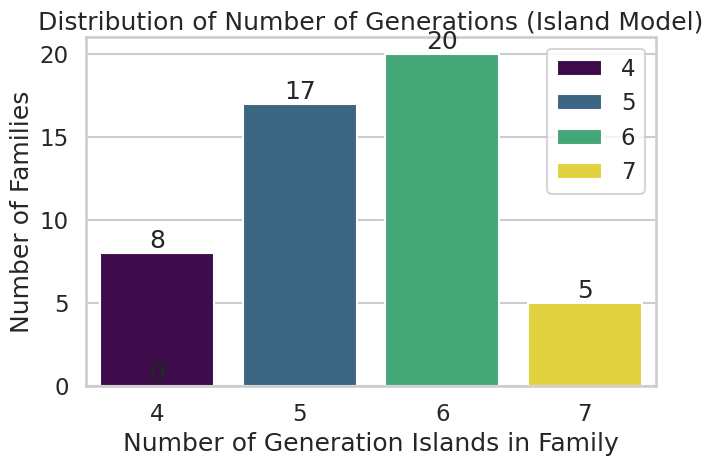

In [65]:
gen_counts = [data["num_generations_islands"] for data in families.values()]

plt.figure(figsize=(7,5))

ax = sns.countplot(x=gen_counts, hue=gen_counts,palette="viridis")

plt.xlabel("Number of Generation Islands in Family")
plt.ylabel("Number of Families")
plt.title("Distribution of Number of Generations (Island Model)")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


**Insight:** Most families exhibit a moderate generational depth (typically 5–6 levels), with few shallow or extremely deep cases, indicating consistent multi-generation structure across the dataset under the island-based generation model.